In [2]:
cd ATML-PA-2/Baseline
ls

SyntaxError: invalid syntax (2971391446.py, line 1)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib
import utils
import architecture
import train
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier
import torch

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")
domains = ['Real World', 'Art', 'Clipart', 'Product']

In [17]:
import matplotlib.pyplot as plt

def analysis(config, model, cache_source=None, cache_target=None):
    train_workflow(model, cache_source, cache_target, config, device=device)
    evaluate_ds(cache_target, model, device)

    latents_s, _ = get_features(model[:-1], cache_source, batchsize=32, device=device)
    latents_t, _ = get_features(model[:-1], cache_target, batchsize=32, device=device)

    latents_s = latents_s.flatten(start_dim=1)
    latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(len(latents_s), dtype=torch.long),
        torch.ones(len(latents_t), dtype=torch.long)
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [29]:
def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

def combine_caches(caches):
    return torch.utils.data.ConcatDataset(caches)

def make_cache(domains, model, transforms=None, layer_name='layer3'):
    ds = OfficeHomeDataset(root_dir, csv_file, domains, transforms)
    return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=32)

def build_model(truncate_from):
    model = resnet_classifier( 
        num_classes=len(classes),
    )
    return _truncate_resnet_from(model, truncate_from)


In [20]:
model = resnet_classifier(num_classes=len(classes))

cache_store = {}
for domain in domains:
    cache_store[domain] = make_cache([domain], model, transform, "layer3")
    print(f"Cached {domain}")

Precomputing up to layer3: 100%|██████████| 137/137 [02:17<00:00,  1.00s/it]


Cached Real World


Precomputing up to layer3: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]


Cached Art


Precomputing up to layer3: 100%|██████████| 137/137 [00:57<00:00,  2.39it/s]


Cached Clipart


Precomputing up to layer3: 100%|██████████| 139/139 [00:58<00:00,  2.39it/s]


Cached Product


In [21]:
pairs = [
    # Low-shift
    ("Product", "Real World"),
    ("Art", "Clipart"),

    # Medium-shift
    ("Product", "Art"),
    ("Art", "Real World"),

    # High-shift
    ("Real World", "Clipart"),
    ("Product", "Clipart")
]

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.53823 |  Train acc: 68.08 %

Test loss: 1.12240 | Test acc: 70.32 %



Training:  10%|█         | 1/10 [00:07<01:06,  7.40s/it]


Epoch 2/10

Train loss: 0.35933 |  Train acc: 92.21 %

Test loss: 1.01700 | Test acc: 73.08 %



Training:  20%|██        | 2/10 [00:14<00:58,  7.35s/it]


Epoch 3/10

Train loss: 0.15644 |  Train acc: 97.09 %

Test loss: 1.00913 | Test acc: 73.08 %



Training:  30%|███       | 3/10 [00:22<00:51,  7.32s/it]


Epoch 4/10

Train loss: 0.07959 |  Train acc: 99.01 %

Test loss: 0.97970 | Test acc: 73.19 %



Training:  40%|████      | 4/10 [00:29<00:43,  7.31s/it]


Epoch 5/10

Train loss: 0.04717 |  Train acc: 99.50 %

Test loss: 0.99153 | Test acc: 72.62 %



Training:  50%|█████     | 5/10 [00:36<00:36,  7.30s/it]


Epoch 6/10

Train loss: 0.03504 |  Train acc: 99.57 %

Test loss: 0.96386 | Test acc: 73.86 %



Training:  60%|██████    | 6/10 [00:43<00:29,  7.30s/it]


Epoch 7/10

Train loss: 0.02700 |  Train acc: 99.55 %

Test loss: 0.99285 | Test acc: 73.54 %



Training:  70%|███████   | 7/10 [00:51<00:21,  7.31s/it]


Epoch 8/10

Train loss: 0.02317 |  Train acc: 99.64 %

Test loss: 0.98510 | Test acc: 74.29 %



Training:  80%|████████  | 8/10 [00:58<00:14,  7.31s/it]


Epoch 9/10

Train loss: 0.01855 |  Train acc: 99.66 %

Test loss: 0.98489 | Test acc: 73.56 %



Training:  90%|█████████ | 9/10 [01:05<00:07,  7.30s/it]


Epoch 10/10

Train loss: 0.01684 |  Train acc: 99.68 %

Test loss: 0.99744 | Test acc: 73.65 %



Training: 100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


Accuracy: 73.65%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.8989    0.9302    0.9143        86
           1     0.8034    0.9495    0.8704        99
           2     0.7193    0.6406    0.6777        64
           3     0.7128    0.8072    0.7571        83
           4     0.9417    0.9798    0.9604        99
           5     0.6842    0.3333    0.4483        78
           6     0.8095    0.8500    0.8293        80
           7     0.8642    0.9589    0.9091        73
           8     0.7882    0.9853    0.8758        68
           9     0.7481    0.9899    0.8522        99
          10     0.8608    0.7083    0.7771        96
          11     0.4643    0.4000    0.4298        65
          12     0.3793    0.5156    0.4371        64
          13     0.8475    0.6579    0.7407        76
          14     0.8784    0.8904    0.8844        73
          15     0.5517    0.7742    0.6443        62
          16     0.91

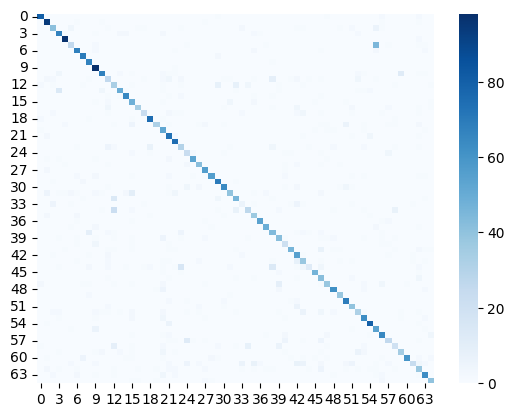

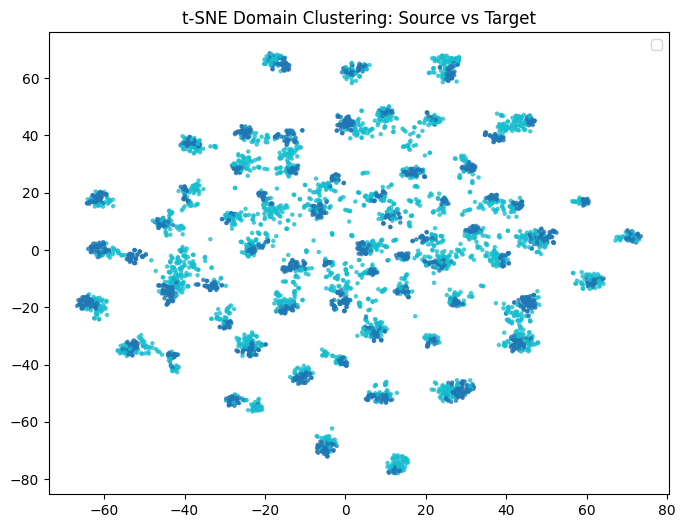

In [41]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}

source, target = ("Product", "Real World")
model = build_model(truncate_from='layer3')
model.layer4.grad = False 
analysis(config, model, cache_store[source], cache_store[target])

Training:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/6

Train loss: 1.74039 |  Train acc: 61.92 %

Test loss: 2.49714 | Test acc: 40.39 %



Training:  17%|█▋        | 1/6 [00:07<00:36,  7.33s/it]


Epoch 2/6

Train loss: 0.50470 |  Train acc: 87.22 %

Test loss: 2.39494 | Test acc: 42.70 %



Training:  33%|███▎      | 2/6 [00:14<00:29,  7.32s/it]


Epoch 3/6

Train loss: 0.23929 |  Train acc: 94.58 %

Test loss: 2.46430 | Test acc: 43.07 %



Training:  50%|█████     | 3/6 [00:21<00:21,  7.32s/it]


Epoch 4/6

Train loss: 0.13087 |  Train acc: 97.64 %

Test loss: 2.56020 | Test acc: 43.02 %



Training:  67%|██████▋   | 4/6 [00:29<00:14,  7.32s/it]


Epoch 5/6

Train loss: 0.07375 |  Train acc: 99.10 %

Test loss: 2.66140 | Test acc: 42.04 %



Training:  83%|████████▎ | 5/6 [00:36<00:07,  7.32s/it]


Epoch 6/6

Train loss: 0.05360 |  Train acc: 99.27 %

Test loss: 2.72671 | Test acc: 41.35 %



Training: 100%|██████████| 6/6 [00:43<00:00,  7.32s/it]


Accuracy: 41.35%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.7119    0.7000    0.7059        60
           1     0.8000    0.2857    0.4211        56
           2     0.5588    0.2969    0.3878        64
           3     0.8462    0.1122    0.1982        98
           4     1.0000    0.5960    0.7468        99
           5     0.8462    0.2222    0.3520        99
           6     0.3882    0.4521    0.4177        73
           7     0.7800    0.8478    0.8125        46
           8     0.5465    0.6026    0.5732        78
           9     0.8667    0.2626    0.4031        99
          10     0.6737    0.6465    0.6598        99
          11     0.0000    0.0000    0.0000        40
          12     0.2281    0.2626    0.2441        99
          13     1.0000    0.1406    0.2466        64
          14     0.6750    0.6429    0.6585        42
          15     0.1368    0.3171    0.1912        41
          16     0.70

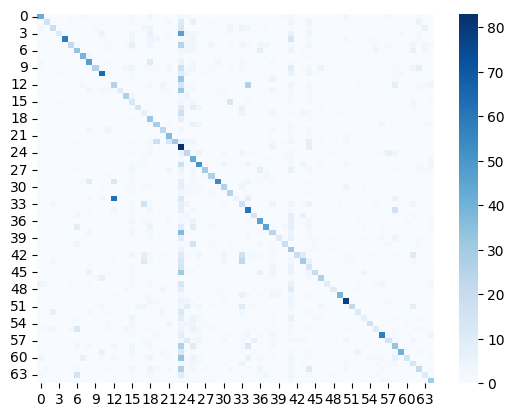

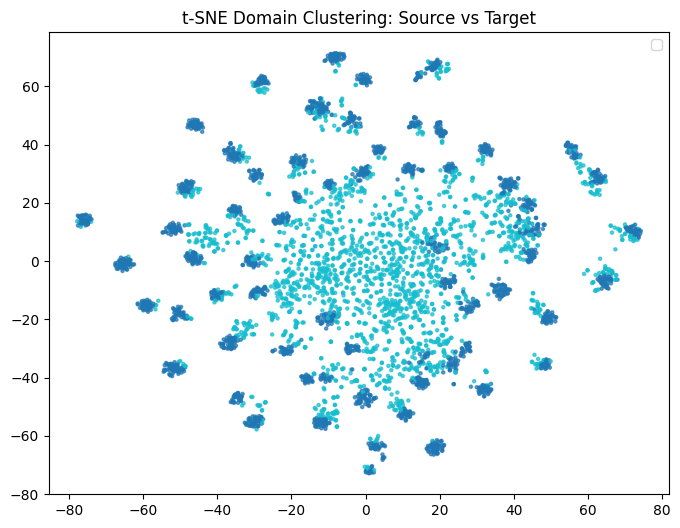

In [67]:
config = {'epochs':6, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}

source, target = ("Real World", "Clipart")
model = build_model(truncate_from='layer3')
model.layer4.grad = False 
analysis(config, model, cache_store[source], cache_store[target])

Training:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1/8

Train loss: 2.65411 |  Train acc: 40.79 %

Test loss: 1.78782 | Test acc: 54.40 %



Training:  12%|█▎        | 1/8 [00:04<00:34,  4.99s/it]


Epoch 2/8

Train loss: 1.10577 |  Train acc: 75.81 %

Test loss: 1.18173 | Test acc: 67.36 %



Training:  25%|██▌       | 2/8 [00:09<00:29,  4.98s/it]


Epoch 3/8

Train loss: 0.54373 |  Train acc: 89.33 %

Test loss: 1.04329 | Test acc: 71.22 %



Training:  38%|███▊      | 3/8 [00:14<00:24,  4.97s/it]


Epoch 4/8

Train loss: 0.29349 |  Train acc: 95.51 %

Test loss: 0.99919 | Test acc: 72.21 %



Training:  50%|█████     | 4/8 [00:19<00:19,  4.96s/it]


Epoch 5/8

Train loss: 0.15087 |  Train acc: 98.19 %

Test loss: 0.98415 | Test acc: 73.08 %



Training:  62%|██████▎   | 5/8 [00:24<00:14,  4.96s/it]


Epoch 6/8

Train loss: 0.09013 |  Train acc: 99.42 %

Test loss: 0.95565 | Test acc: 73.47 %



Training:  75%|███████▌  | 6/8 [00:29<00:09,  4.97s/it]


Epoch 7/8

Train loss: 0.06115 |  Train acc: 99.55 %

Test loss: 0.96548 | Test acc: 73.08 %



Training:  88%|████████▊ | 7/8 [00:34<00:04,  4.97s/it]


Epoch 8/8

Train loss: 0.05153 |  Train acc: 99.38 %

Test loss: 0.95886 | Test acc: 73.40 %



Training: 100%|██████████| 8/8 [00:39<00:00,  4.97s/it]


Accuracy: 73.40%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9367    0.8605    0.8970        86
           1     0.9293    0.9293    0.9293        99
           2     0.5843    0.8125    0.6797        64
           3     0.7349    0.7349    0.7349        83
           4     0.9706    1.0000    0.9851        99
           5     0.7361    0.6795    0.7067        78
           6     0.7053    0.8375    0.7657        80
           7     0.6083    1.0000    0.7565        73
           8     0.8481    0.9853    0.9116        68
           9     0.9588    0.9394    0.9490        99
          10     0.8061    0.8229    0.8144        96
          11     0.4706    0.3692    0.4138        65
          12     0.4638    0.5000    0.4812        64
          13     0.6905    0.7632    0.7250        76
          14     0.9265    0.8630    0.8936        73
          15     0.6230    0.6129    0.6179        62
          16     0.79

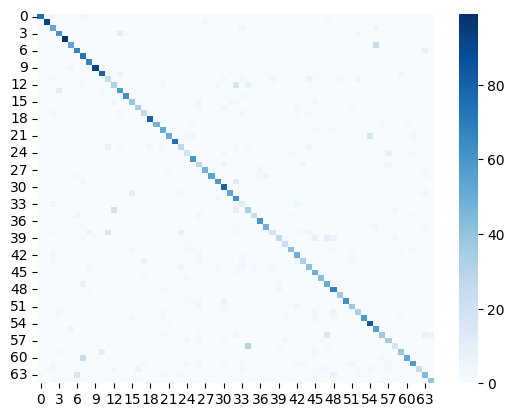

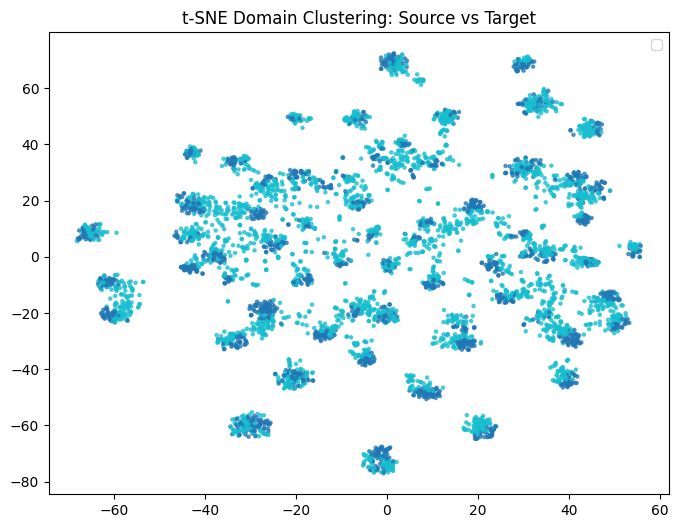

In [44]:
config = {'epochs':8, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}

source, target = ("Art", "Real World")
model = build_model(truncate_from='layer3')

model.layer4.grad = False 
analysis(config, model, cache_store[source], cache_store[target])

Training:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1/8

Train loss: 1.70921 |  Train acc: 62.45 %

Test loss: 2.39747 | Test acc: 40.85 %



Training:  12%|█▎        | 1/8 [00:07<00:50,  7.24s/it]


Epoch 2/8

Train loss: 0.49720 |  Train acc: 87.88 %

Test loss: 2.44037 | Test acc: 42.11 %



Training:  25%|██▌       | 2/8 [00:14<00:43,  7.22s/it]


Epoch 3/8

Train loss: 0.23962 |  Train acc: 94.51 %

Test loss: 2.60358 | Test acc: 40.85 %



Training:  38%|███▊      | 3/8 [00:21<00:36,  7.22s/it]


Epoch 4/8

Train loss: 0.13295 |  Train acc: 97.36 %

Test loss: 2.51185 | Test acc: 42.73 %



Training:  50%|█████     | 4/8 [00:28<00:28,  7.23s/it]


Epoch 5/8

Train loss: 0.07384 |  Train acc: 99.01 %

Test loss: 2.61994 | Test acc: 41.90 %



Training:  62%|██████▎   | 5/8 [00:36<00:21,  7.23s/it]


Epoch 6/8

Train loss: 0.04984 |  Train acc: 99.24 %

Test loss: 2.66115 | Test acc: 41.42 %



Training:  75%|███████▌  | 6/8 [00:43<00:14,  7.22s/it]


Epoch 7/8

Train loss: 0.04280 |  Train acc: 99.33 %

Test loss: 2.66253 | Test acc: 42.18 %



Training:  88%|████████▊ | 7/8 [00:50<00:07,  7.22s/it]


Epoch 8/8

Train loss: 0.03554 |  Train acc: 99.31 %

Test loss: 2.64723 | Test acc: 42.68 %



Training: 100%|██████████| 8/8 [00:57<00:00,  7.22s/it]


Accuracy: 42.68%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.7679    0.7167    0.7414        60
           1     0.6786    0.3393    0.4524        56
           2     0.6667    0.3125    0.4255        64
           3     0.7500    0.0918    0.1636        98
           4     1.0000    0.6364    0.7778        99
           5     0.8077    0.2121    0.3360        99
           6     0.3924    0.4247    0.4079        73
           7     0.6964    0.8478    0.7647        46
           8     0.5155    0.6410    0.5714        78
           9     0.6744    0.2929    0.4085        99
          10     0.7857    0.5556    0.6509        99
          11     0.0000    0.0000    0.0000        40
          12     0.2439    0.1010    0.1429        99
          13     0.6190    0.2031    0.3059        64
          14     0.6667    0.6190    0.6420        42
          15     0.1579    0.2927    0.2051        41
          16     0.80

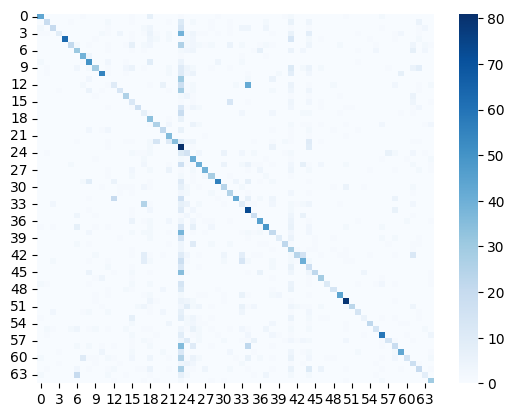

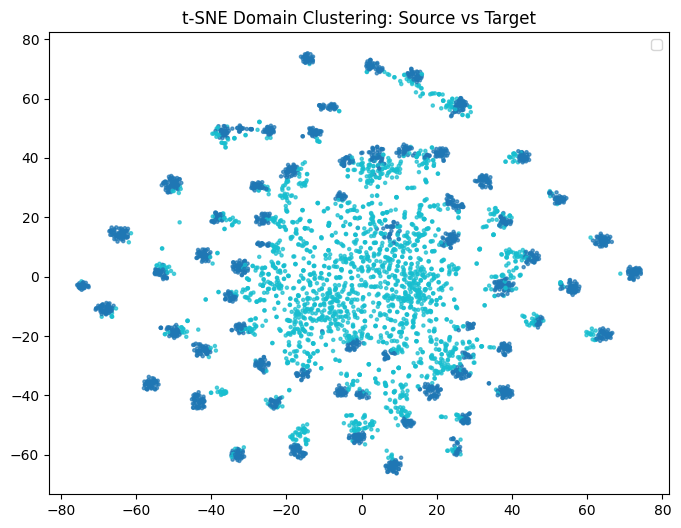

In [ ]:
config = {'epochs':8, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}

source, target = ("Real World", "Clipart")
model = build_model(truncate_from='layer3')

model.layer4.grad = False 
analysis(config, model, cache_store[source], cache_store[target])

In [62]:
sources = ["Art", "Real World", "Product"]
target = "Clipart"
# #benchmark for domain adaptation
source_ds = combine_caches([cache_store[domain] for domain in sources])
target_ds = cache_store[target]

torch.manual_seed(100)
_, benchmark = torch.utils.data.random_split(target_ds, [0.8, 0.2])

Training:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/5

Train loss: 1.23484 |  Train acc: 69.86 %

Test loss: 2.26101 | Test acc: 45.59 %



Training:  20%|██        | 1/5 [00:15<01:00, 15.23s/it]


Epoch 2/5

Train loss: 0.40190 |  Train acc: 89.16 %

Test loss: 2.37957 | Test acc: 44.54 %



Training:  40%|████      | 2/5 [00:30<00:45, 15.25s/it]


Epoch 3/5

Train loss: 0.17806 |  Train acc: 95.57 %

Test loss: 2.42619 | Test acc: 45.84 %



Training:  60%|██████    | 3/5 [00:45<00:30, 15.24s/it]


Epoch 4/5

Train loss: 0.08368 |  Train acc: 98.24 %

Test loss: 2.49361 | Test acc: 45.59 %



Training:  80%|████████  | 4/5 [01:00<00:15, 15.23s/it]


Epoch 5/5

Train loss: 0.04728 |  Train acc: 99.13 %

Test loss: 2.49284 | Test acc: 46.48 %



Training: 100%|██████████| 5/5 [01:16<00:00, 15.23s/it]


Accuracy: 46.48%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.6364    0.7000    0.6667        60
           1     0.6667    0.1429    0.2353        56
           2     0.6207    0.2812    0.3871        64
           3     0.8750    0.1429    0.2456        98
           4     0.9733    0.7374    0.8391        99
           5     0.6897    0.2020    0.3125        99
           6     0.4167    0.4795    0.4459        73
           7     0.6119    0.8913    0.7257        46
           8     0.5412    0.5897    0.5644        78
           9     0.4699    0.3939    0.4286        99
          10     0.8125    0.5253    0.6380        99
          11     0.2105    0.2000    0.2051        40
          12     0.3868    0.4141    0.4000        99
          13     0.6875    0.1719    0.2750        64
          14     0.5600    0.6667    0.6087        42
          15     0.1250    0.3659    0.1863        41
          16     0.84

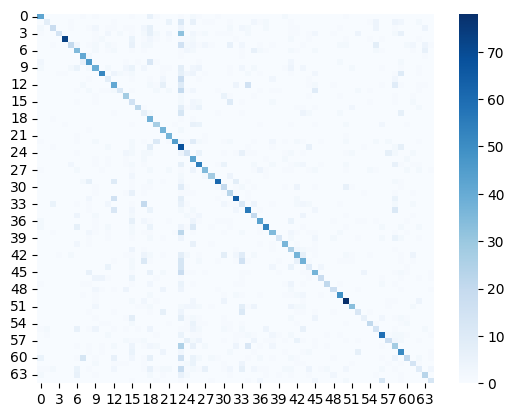

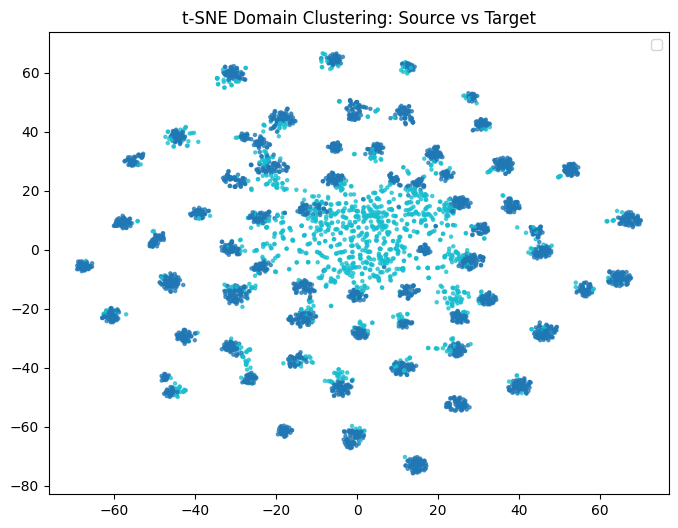

In [65]:
config = {'epochs':5, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}

model = build_model(truncate_from='layer3')

model.layer4.grad = False
analysis(config, model, source_ds, target_ds)

Training:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/5

Train loss: 1.29345 |  Train acc: 69.53 %

Test loss: 2.31597 | Test acc: 44.79 %



Training:  20%|██        | 1/5 [00:13<00:53, 13.46s/it]


Epoch 2/5

Train loss: 0.42148 |  Train acc: 88.69 %

Test loss: 2.34486 | Test acc: 44.67 %



Training:  40%|████      | 2/5 [00:26<00:40, 13.44s/it]


Epoch 3/5

Train loss: 0.19623 |  Train acc: 95.24 %

Test loss: 2.46285 | Test acc: 44.90 %



Training:  60%|██████    | 3/5 [00:40<00:26, 13.43s/it]


Epoch 4/5

Train loss: 0.09090 |  Train acc: 98.23 %

Test loss: 2.49541 | Test acc: 45.02 %



Training:  80%|████████  | 4/5 [00:54<00:13, 13.58s/it]


Epoch 5/5

Train loss: 0.05069 |  Train acc: 99.14 %

Test loss: 2.58757 | Test acc: 46.05 %



Training: 100%|██████████| 5/5 [01:07<00:00, 13.53s/it]


Accuracy: 46.05%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.5556    0.5263         9
           1     1.0000    0.3000    0.4615        10
           2     0.6667    0.2000    0.3077        10
           3     1.0000    0.0909    0.1667        22
           4     1.0000    0.8800    0.9362        25
           5     1.0000    0.3529    0.5217        17
           6     0.6000    0.4000    0.4800        15
           7     0.5000    0.9000    0.6429        10
           8     0.3750    0.4615    0.4138        13
           9     0.5556    0.2273    0.3226        22
          10     0.5000    0.6500    0.5652        20
          11     0.0000    0.0000    0.0000        10
          12     0.4167    0.3846    0.4000        26
          13     0.6667    0.2222    0.3333         9
          14     0.6000    0.5000    0.5455         6
          15     0.1111    0.1818    0.1379        11
          16     1.00

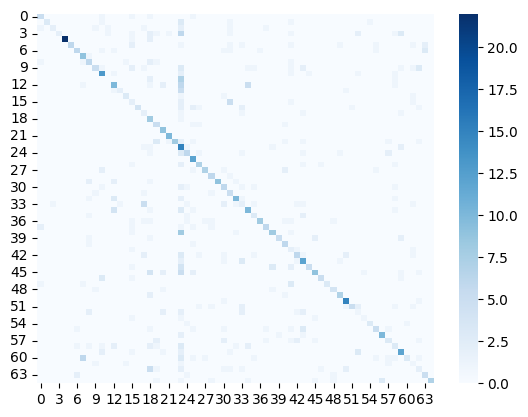

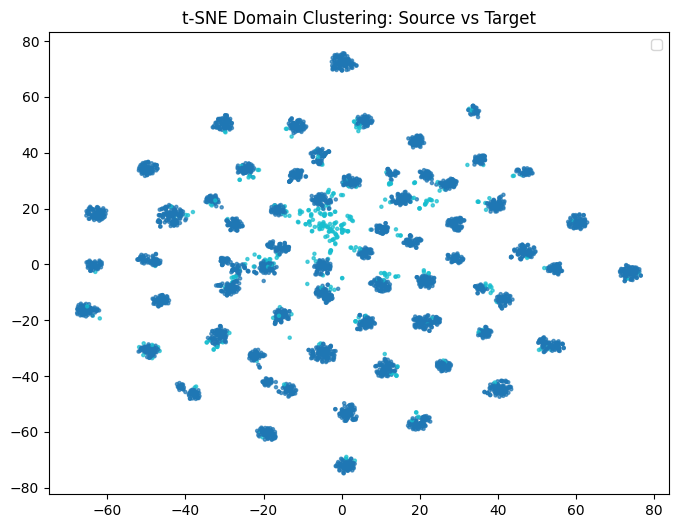

In [63]:
config = {'epochs':5, 'lr':9e-4, 'batch_size':32, 'weight_decay':1e-2}

model = build_model(truncate_from='layer3')

model.layer4.grad = False
analysis(config, model, source_ds, benchmark)